# Plot Comparisons

`comparisons` and `plot_comparisons` are a part of Bambi's sub-package `plots` that feature a set of functions used to interpret complex regression models. This sub-package is inspired by the R package [marginaleffects](https://vincentarelbundock.github.io/marginaleffects/articles/predictions.html#conditional-adjusted-predictions-plot). These two functions allow the modeler to **compare** the predictions made by a model for different contrast and covariate values. Below, it is described why comparing predictions is useful in interpreting generalized linear models (GLMs), how this methodology is implemented in Bambi, and how to use `comparisons` and `plot_comparisons`. It is assumed that the reader is familiar with the basics of GLMs. If not, refer to the Bambi [Basic Building Blocks](https://bambinos.github.io/bambi/notebooks/how_bambi_works.html#Link-functions) example.

Due to the link function in a GLM, there are typically three quantities of interest to interpret:

1. the linear predictor $\eta = X\beta$ where $X$ is an $n$ x $p$ matrix of explanatory variables.
2. the mean $\mu = g^{-1}(\eta)$ where the link function $g(\cdot)$ relates the linear predictor to the mean of the outcome variable $\mu = g^{-1}(\eta) = g^{-1}(X\beta)$
3. the response variable $Y \sim \mathcal{D}(\mu, \theta)$ where $\mu$ is the mean parameter and $\theta$ is (possibly) a vector that contains all the other "auxillary" parameters of the distribution.
 
Often, with GLMs, $\eta$ is linear in the parameters, but nonlinear in relation of inputs to the outcome $Y$ due to the link function $g$. Thus, as modelers, we are usually more interested in interpreting (2) and (3). For example, in logistic regression, the linear predictor is on the log-odds scale, but the response variable is on the probability scale. In Poisson regression, the linear predictor is on the log-scale, but the response variable is on the count scale. Referring back to logistic regression, a specified difference in one of the $x$ variables does _not_ correspond to a constant difference in the the probability of the outcome.

It is often helpful with GLMs, to the modeler and audience, to have a summary that gives the expected difference in the outcome corresponding to a unit difference in each of the input variables. Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predicted comparisons.

## Average Predictive Comparisons

Here, we adopt the notation from Chapter 14.4 of [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/) to describe average predictive comparisons. Assume we have fit a Bambi model predicting an outcome $Y$ based on inputs $X$ and parameters $\theta$. Consider the following scalar inputs:

$$u: \text{the input of interest}$$
$$v: \text{all the other inputs}$$
$$X = (u, v)$$

Suppose for the input of interest, we are interested in comparing $u^{\text{high}}$ to $u^{\text{low}}$ (perhaps age = $60$ and $40$ respectively) with all other inputs $v$ held constant. The _predictive difference_ in the outcome changing **only** $u$ is:

$$\text{predictive difference (comparison)} = \mathbb{E}(y|u^{\text{high}}, v, \theta) - \mathbb{E}(y|u^{\text{low}}, v, \theta)$$

Selecting the maximum and minimum values of $u$ and averaging over all other inputs $v$ in the data gives you a new "hypothetical" dataset and corresponds to counting all pairs of transitions of $(u^\text{low})$ to $(u^\text{high})$, i.e., differences in $u$ with $v$ held constant. The difference between these two terms is the average predictive comparison.

### Computing Average Predictive Comparisons

The objective of average predictive comparisons is to compute the expected difference in the outcome corresponding to three different scenarios for $u$ and $v$ where $u$ is either provided by the user, else a default value is computed by Bambi (described in the default values section). The three scenarios are:

1. user provided values for $v$.
2. a grid of equally spaced and central values for $v$.
3. empirical distribution (original data used to fit the model) for $v$. 

In the case of (1) and (2) above, Bambi assembles all pairwise combinations (transitions) of $u$ and $v$ into a new "hypothetical" dataset. In (3), Bambi uses the original $v$, but replaces $u$ with the user provided value or the default value computed by Bambi. In each scenario, predictions are made on the data using the fitted model. Once the predictions are made, comparisons are computed using the postrior chains and draws by taking the difference in the predicted outcome for each pair of transitions. The average of these differences is the average predictive comparison. 

Thus, the goal of `comparisons` and `plot_comparisons` is to provide the modeler with a summary and visualization of the average predicted comparisons. Below, we demonstrate how to compute and plot _average predictive comparisons_ with `comparisons` and `plot_comparions` using several examples.

In [2]:
import arviz as az
import numpy as np
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison, comparisons

## Zero Inflated Poisson

We model and predict how many fish are caught by visitors at a state park. Many visitors catch zero fish, either because they did not fish at all, or because they were unlucky. We would like to explicitly model this bimodal behavior (zero versus non-zero) using a Zero Inflated Poisson model, and to compare how different inputs of interest $u$ and other covariate values $v$ are associated with the number of fish caught. A description of the data can be found below:

**todo: add data description**

In [3]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]
fish_data["livebait"] = fish_data["livebait"].astype("category")
fish_data["camper"] = fish_data["camper"].astype("category")

In [4]:
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    family='zero_inflated_poisson'
)

fish_idata = fish_model.fit(
    draws=1000, 
    target_accept=0.95, 
    random_seed=1234, 
    chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


### User Provided Values

First, an example of scenario 1 (user provided values) is given below. In both `plot_comparisons` and `comparisons`, $u$ and $v$ are represented by `contrast` and `conditional`, respectively. The modeler has the ability to pass their own values for `contrast` and `conditional` by using a dictionary where the key, value pairs are the covariate and value(s) to use. For example, if we wanted to compare the number of fish caught for $4$ versus $1$ `persons` conditional on a range of `child` and `livebait` values, we would pass the following dictionary. However, the user is not limited to passing a list for the values. A `np.array` can also be used.

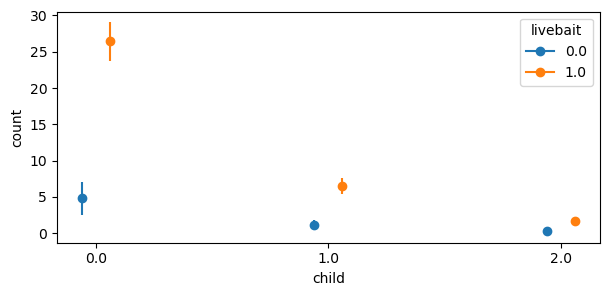

In [5]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]},
) 
fig.set_size_inches(7, 3)

The plot above shows that, comparing $4$ to $1$ persons given $0$ children and using livebait, the expected difference is about $26$ fish. When not using livebait, the expected difference decreases substantially to about $5$ fish. Using livebait with a group of people is associated with a much larger expected difference in the number of fish caught. Oh, and don't bring children fishing if you have plans to catch dinner.

### Multiple contrast values

Users can also perform comparisons on multiple contrast values. For example, if we wanted to compare the number of fish caught between $(1, 2)$, $(1, 4)$, and $(2, 4)$ `persons` conditional on a range of values for `child` and `livebait`.

In [ ]:
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast={"persons": [1, 2, 4]},
    conditional={"child": [0, 1, 2], "livebait": [0, 1]}
)

### Default contrast and conditional values

You are not required to pass values for `contrast` and `conditional`. If you do not pass values for `contrast` and `conditional`, Bambi will compute default values for you. 

The default value for `contrast` is a _centered difference_ at the mean for a contrast variable with a numeric dtype, and _unique levels_ for a contrast varaible with a categorical dtype. The default values for `conditional` depend on the order of the covariates passed. 

**todo: add more details about default values**

Lets say we are interested in comparing the number of fish caught for `livebait` = [0, 1] conditional on the number of people.

In [ ]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
) 
fig.set_size_inches(7, 3)

By default, if no value is passed with `contrast`, then the mean or mode is computed (depending on the data type used to fit the model) as the contrast value. As live bait is category data type and no value was passed, the contrast value is [0, 1]. By default, `comparisons` compares $u^\text{high}$ to $u^\text{low}$. Thus, in this example, $u^\text{high}$ = 1 and $u^\text{low}$ = 0. The plot shows us that comparing a group of two people who used live bait and no live bait, the expected difference in the number of fish caught is about $2$. As the number of people in the group increases, the expected difference also increases. 

We can call `comparisons` directly to view a summary dataframe that includes the term $u$ and its contrast, the specified `conditional` covariate, and the expected difference in the outcome with the uncertainty interval (by default the 94% highest density interval is computed). We see that `camper` and `child` are also in the summary dataframe. This is because for unspecified covariates, `comparisons` and `plot_comparisons` computes a default value (mean or mode based on the data type of the covariate). Thus, $v$ = `persons`, `camper`, `child`.

In [ ]:
comparisons_df = comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional="persons",
)
comparisons_df.head(10)

Furthermore, `conditional` is not limited to one covariate. We can pass a list of covariates to condition on. For example, we can also include `camper`.

In [ ]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=["persons", "camper"],
) 
fig.set_size_inches(7, 3)

### Unit level contrasts

Evaluating average predictive comparisons at central values for the conditional covariates $v$ can be problematic when the inputs have a large variance since no single central value (mean, median, etc.) is representative of the covariate. This is especially true when $v$ exhibits bi or multimodality. Thus, it may be desireable to use the empirical distribution of $v$ to compute the predictive comparisons, and then average over a specific or set of covariates to obtain the average predictive comparisons. To achieve unit level contrasts, do not pass a parameter into `conditional` and or specify `None`.

In [ ]:
unit_level = comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
)

# empirical distribution
print(unit_level.shape[0] == fish_model.data.shape[0])
unit_level.head(10)

#### Marginalizing over covariates

Since the empirical distrubution is used for computing the average predictive comparisons, the same number of rows (250) is returned as the data used to fit the model. To average over a covariate, use the `average_by` argument. If `True` is passed, then `comparisons` averages over all covariates. Else, if a single or list of covariates are passed, then `comparisons` averages by the covariates passed.

In [ ]:
# marginalize over all covariates
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by=True
)

In [ ]:
# average by number of persons
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
)

In [ ]:
# average by number of persons and camper
comparisons(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by=["persons", "camper"]
)

It is still possible to use `plot_comparisons` when passing an argument to `average_by`. In the plot below, the empirical distribution is used to compute unit level contrasts for `livebait` and then averaged over `persons` to obtain the average predictive comparisons. The plot below is similar to the second plot in this notebook. The differences being that: (1) a pairwise transition grid is defined for the second plot above, whereas the empirical distribution is used in the plot below, and (2) in the plot below, we marginalized over the other covariates in the model (thus the reason for not having a camper group, and a reduction in the uncertainty interval).

In [ ]:
fig, ax = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast="livebait",
    conditional=None,
    average_by="persons"
)
fig.set_size_inches(7, 3)

Notice how the contrast $u$ varies while the covariates $v$ are held constant. Currently, however, plotting multiple contrast values can be difficult to interpret since the contrast is "abstracted" away onto the y-axis. Thus, it would be difficult to interpret which portion of the plot corresponds to which contrast value. This is something I am still working on.

In [ ]:
wells = pd.read_csv("http://www.stat.columbia.edu/~gelman/arm/examples/arsenic/wells.dat", delimiter="\s+")
wells.dtypes

In [ ]:
wells["switch"] = pd.Categorical(wells["switch"])
wells["assoc"] = pd.Categorical(wells["assoc"])
wells["educ4"] = wells["educ"] // 4
wells["educ4"] = pd.Categorical(wells["educ4"], ordered=True)
wells["dist100"] = wells["dist"] / 100

In [ ]:
wells_model = bmb.Model(
    "switch ~ dist100 + arsenic + educ",
    wells,
    family="bernoulli",
    link="logit"
)

wells_idata = wells_model.fit(
    draws=1000,
    target_accept=0.95,
    random_seed=1234,
    chains=4
)

In [ ]:
az.summary(wells_idata)

In [ ]:
comparisons(
    model=wells_model,
    idata=wells_idata,
    contrast={"dist100": [0, 1]},
    average_by=True
)